# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()

c:\Users\ShwetankPC\anaconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\ShwetankPC\AppData\Local\Temp\ipykernel_70632\4071503124.py:6: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedb

In [2]:
df.head()

ticker       Date       Open       High        Low      Close  Adj Close  \
0     IP 2000-01-03  53.232025  53.465500  51.831181  51.831181  22.170971   
1     IP 2000-01-04  51.364235  52.473236  49.963390  50.547077  21.621695   
2     IP 2000-01-05  50.488708  52.706707  50.080128  52.298130  22.370716   
3     IP 2000-01-06  52.006287  53.698971  51.539337  53.348763  22.820126   
4     IP 2000-01-07  54.165920  56.033710  53.815708  54.749603  23.419348   

    Volume     sector                                       subsector  year  \
0  2009112  Materials  Paper & Plastic Packaging Products & Materials  2000   
1  2038130  Materials  Paper & Plastic Packaging Products & Materials  2000   
2  2710583  Materials  Paper & Plastic Packaging Products & Materials  2000   
3  5865434  Materials  Paper & Plastic Packaging Products & Materials  2000   
4  6483811  Materials  Paper & Plastic Packaging Products & Materials  2000   

   Close_lag_1   returns  positive_return  target  
0    32.658314  0.587075                1     0.0  
1    51.831181 -0.024775                0     1.0  
2    50.547077  0.034642                1     1.0  
3    52.298130  0.020089                1     1.0  
4    53.348763  0.026258                1     0.0

## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [3]:
returns = df[[ 'returns']].dropna()
returns.describe()

returns
count  2.742698e+06
mean   4.620360e-03
std    5.263662e-01
min   -9.980031e-01
25%   -9.165308e-03
50%    4.856838e-04
75%    1.018485e-02
max    6.978800e+02

In [4]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

StandardScaler()

In [5]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

returns
count  2.742698e+06
mean  -3.924866e-18
std    1.000000e+00
min   -1.904802e+00
25%   -2.619026e-02
50%   -7.855133e-03
75%    1.057153e-02
max    1.325836e+03

###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='sector'>

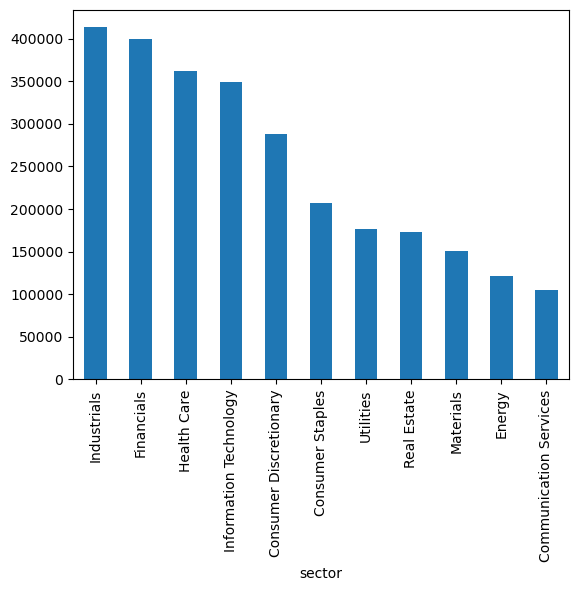

In [5]:
df['sector'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [10]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['sector']])

OneHotEncoder()

In [8]:
sector_enc = onehot.transform(df[['sector']])
sector_enc.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [10]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [11]:
X0 = df[['sector']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [12]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [13]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [14]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5116172126164114,
 'accuracy_score_test': 0.5102070951981624,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6928619263103287,
 'log_loss_test': 0.6929298344572438,
 'f1_score_train': 0.6769137164439522,
 'f1_score_test': 0.6756783183186084}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [7]:
from sklearn.compose import ColumnTransformer

In [18]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

piped = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

In [13]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=15))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [15]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [17]:
# Schema
X = df[['returns', 'Volume', 'sector']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [19]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6923358868569375,
 'log_loss_test': 0.6922996029737793,
 'cohen_kappa_train': 0.018575684430021333,
 'cohen_kappa_test': 0.017427446827936288,
 'f1_score_train': 0.6213353566684393,
 'f1_score_test': 0.6219881472893992,
 'accuracy_score_train': 0.5152450314072714,
 'accuracy_score_test': 0.5155435337441208}

In [20]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6886710911559112,
 'log_loss_test': 0.7543049083634421,
 'cohen_kappa_train': 0.029802459682024218,
 'cohen_kappa_test': 0.01477616883593702,
 'f1_score_train': 0.631843223977262,
 'f1_score_test': 0.6272365230938898,
 'accuracy_score_train': 0.5212342322736632,
 'accuracy_score_test': 0.5147505195610165}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [21]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [22]:
pd.DataFrame(d3_dict)

fit_time  score_time  test_accuracy  train_accuracy   test_f1  train_f1  \
0  36.359176    1.829782       0.514110        0.520514  0.635039  0.639262   
1  36.815007    1.944183       0.516724        0.521351  0.632947  0.638055   
2  35.600502    1.841586       0.514216        0.520855  0.632817  0.641033   
3  35.563997    1.868707       0.513765        0.521399  0.629252  0.635127   
4  37.279313    1.867546       0.513747        0.520973  0.639944  0.642514   

   test_precision  train_precision  test_recall  train_recall  test_roc_auc  \
0        0.515515         0.519471     0.826716      0.830860      0.512790   
1        0.517422         0.520149     0.814887      0.825082      0.516762   
2        0.515740         0.519546     0.818659      0.836677      0.512363   
3        0.515684         0.520450     0.806968      0.814622      0.512485   
4        0.514944         0.519495     0.845084      0.841875      0.512307   

   train_roc_auc  test_neg_log_loss  train_neg_log_loss  test_neg_brier_score  \
0       0.524923          -0.751156           -0.688962             -0.250886   
1       0.526269          -0.768426           -0.688591             -0.250854   
2       0.525102          -0.810380           -0.689076             -0.251922   
3       0.525988          -0.775841           -0.688753             -0.251269   
4       0.525785          -0.749717           -0.688908             -0.250887   

   train_neg_brier_score  
0              -0.248270  
1              -0.248132  
2              -0.248308  
3              -0.248180  
4              -0.248241

In [ ]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [ ]:
pd.DataFrame(d15_dict).mean()